In [ ]:
import torch

import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns

import os
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from tqdm.notebook import tqdm
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram
from functions.processing.recordings import process_and_save_as_pt
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

2025-12-31 13:44:26,233	INFO worker.py:1839 -- Calling ray.init() again after it has already been called.


Ray is initialized!
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    "batch_size": tune.lograndint(2, 32),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [5]:
concurrent_trials = 2

# Load  dataset
recording_path="F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
label_path="F:\\Persönliches\\Git\\BioOTon"
ds = SpectroDataset(recording_path, label_path, device = 'cuda')

trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(pid=gcs_server) [2025-12-31 13:00:51,030 E 4424 35444] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-31 13:00:55,559 E 6492 39616] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27752869_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\26752896_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22348347_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\23042657_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\23140111_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\28033229_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27933295_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\28614839_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22763269_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27644928_audio.pt
(train_model pid=4556) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22364799_audio.pt
(train_mod

2025-12-31 13:09:13,101	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_24667a70
Traceback (most recent call last):
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py", line 2967, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py", lin

(train_model pid=9320) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27729647_audio.pt [repeated 654x across cluster]
(train_model pid=9320) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27579111_audio.pt [repeated 272x across cluster]
(train_model pid=9320) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27439169_audio.pt [repeated 264x across cluster]
(train_model pid=21524) F:\Persönliches\Git\BioOTon\AudioTensors\27996621_audio.pt
(train_model pid=9320)  
(train_model pid=9320) F:\Persönliches\Git\BioOTon\AudioTensors\27833711_audio.pt
(train_model pid=21524)  F:\Persönliches\Git\BioOTon\AudioTensors\27641570_audio.pt
(train_model pid=21524) F:\Persönliches\Git\BioOTon\AudioTensors\27655942_audio.pt
(train_model pid=21524) 
(train_model pid=21524)  F:\Persönliches\Git\BioOTon\AudioTensors\27316654_audio.pt
(train_model pid=9320) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27669392_audio.pt [repeated 1335x across cluster]
(train_model pid=21524) F:\Persönliches\Git\BioOT

2025-12-31 13:13:02,068	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_5b2c716d
Traceback (most recent call last):
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py", line 2967, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py", lin

(train_model pid=3216) [7,   286] loss: 836.590059 vloss: 2.402327
(train_model pid=3216) Model improved; checkpoint saved at loss 2.4023
(train_model pid=3216) Getting F:\Persönliches\Git\BioOTon\AudioTensors\23066269_audio.pt [repeated 1078x across cluster]
(train_model pid=3216) 7  :  5
(train_model pid=3216)  F:\Persönliches\Git\BioOTon\AudioTensors\27555119_audio.pt
(train_model pid=3216) Getting F:\Persönliches\Git\BioOTon\AudioTensors\23063882_audio.pt [repeated 875x across cluster]
(train_model pid=3216) F:\Persönliches\Git\BioOTon\AudioTensors\27832076_audio.pt
(train_model pid=3216) 7  :  5
(train_model pid=7416)  F:\Persönliches\Git\BioOTon\AudioTensors\23254784_audio.pt
(train_model pid=3216) 
(train_model pid=7416) 
(train_model pid=3216) [8,   286] loss: 757.023368 vloss: 2.322163
(train_model pid=3216) Model improved; checkpoint saved at loss 2.3222
(train_model pid=7416) Getting F:\Persönliches\Git\BioOTon\AudioTensors\26828866_audio.pt [repeated 1463x across cluster]
(

2025-12-31 13:13:37,471	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-12-31 13:13:37,513	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0412s.


(train_model pid=7416) 
(train_model pid=3216) F:\Persönliches\Git\BioOTon\AudioTensors\22303124_audio.pt
(train_model pid=7416) 
(train_model pid=7416) 14  :  2
(train_model pid=7416) [3,   143] loss: 200.518096 vloss: 26.679714
(train_model pid=3216) Getting F:\Persönliches\Git\BioOTon\AudioTensors\28130746_audio.pt [repeated 1729x across cluster]
(train_model pid=3216) F:\Persönliches\Git\BioOTon\AudioTensors\28392157_audio.pt
(train_model pid=3216) 


2025-12-31 13:13:44,313	ERROR tune.py:1037 -- Trials did not complete: [train_model_24667a70, train_model_5b2c716d]
2025-12-31 13:13:44,314	INFO tune.py:1041 -- Total run time: 776.28 seconds (769.41 seconds for the tuning loop).
2025-12-31 13:13:44,315	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)


(train_model pid=3216) F:\Persönliches\Git\BioOTon\AudioTensors\19133357_audio.pt
(train_model pid=3216) 


ResultGrid<[
  Result(
    metrics={'loss': 2.251155943274498, 'accuracy': 0.54},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_8d93db',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.073420329093933, 'accuracy': 0.54},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_4acc78',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    error='RayTaskError(RuntimeError)',
    metrics={},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_24667a',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.496294915676117, 'accuracy': 0.38},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_2e98f1',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 7.078151019414266, 'accuracy': 0.27},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_c8b0ee',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    error=

In [6]:
model, df = getBestModel(return_df=True)

Best Hyperparameters: {'lr': 0.00018217292899600795, 'batch_size': 2, 'nfft': 4096, 'scale': 3.3285967358612116, 'power': 1.7831184599879397, 'patience': 9, 'EarlyDelta': 0.0549733297167698, 'epochs': 17, 'l1': 0.003237281614796639, 'l2': 0.0015806433029207302}


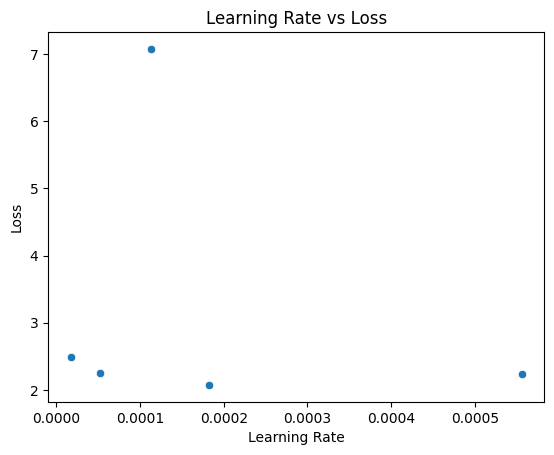

In [7]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [8]:
%tensorboard --logdir runs/single_points/

Reusing TensorBoard on port 6008 (pid 22976), started 9 days, 1:41:46 ago. (Use '!kill 22976' to kill it.)

In [11]:
train_indices, test_indices, val_indices  = splitDataset(ds)
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

Getting F:\Persönliches\Git\BioOTon\AudioTensors\23857077_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294964_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26223311_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294960_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22329529_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26574358_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22303197_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\23848329_audio.pt
Best Hyperparameters: {'lr': 0.00018217292899600795, 'batch_size': 2, 'nfft': 4096, 'scale': 3.3285967358612116, 'power': 1.7831184599879397, 'patience': 9, 'EarlyDelta': 0.0549733297167698, 'epochs': 17, 'l1': 0.003237281614796639, 'l2': 0.0015806433029207302}
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398674_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398677_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22370546_audio.pt
G

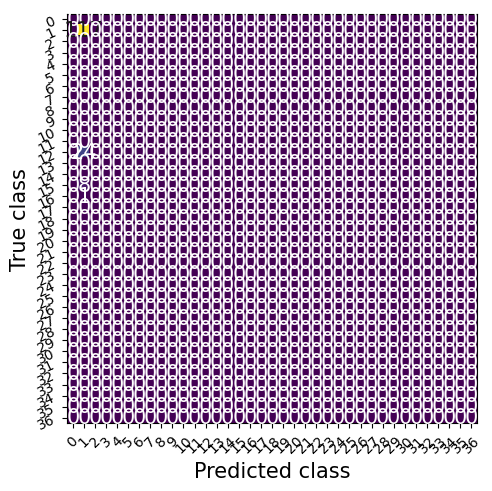

Recall of the custom cnn: tensor(0.2500, device='cuda:0')
F1-score of the custom cnn: tensor(0.2191, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.2500, device='cuda:0')


In [14]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel()
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())

In [10]:
# --- Setup Paths ---
input_dir = Path("Z:\\Audio_data\\Dawn_chorus_conversion_flac")
output_dir = Path("./AudioTensors")
output_dir.mkdir(exist_ok=True)

# Find all files
audio_files = list(input_dir.glob("*.flac"))

print(f"Total files to process: {len(audio_files)}")

# --- Execution ---
# We use max_workers to run multiple FFmpeg instances at once
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Use a list to hold the results so tqdm can track progress
    results = list(tqdm(
        executor.map(lambda f: process_and_save_as_pt(f, output_dir, target_sr=16000), audio_files), 
        total=len(audio_files),
        desc="Converting to .pt"
    ))

print(f"Success: {sum(results)} | Failed: {len(results) - sum(results)}")

Total files to process: 43826


Converting to .pt:   0%|          | 0/43826 [00:00<?, ?it/s]

Success: 43826 | Failed: 0


In [ ]:
input_dir = Path("./AudioTensors")
audio_files = list(input_dir.glob("*.pt"))

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Use a list to hold the results so tqdm can track progress
    results = list(tqdm(
        executor.map(lambda f: loadPT(f), audio_files), 
        total=len(audio_files),
        desc="Loading files"
    ))

Loading files:   0%|          | 0/43826 [00:00<?, ?it/s]